In [1]:
!pip install transformers
!pip install datasets
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.7 MB/s eta 0:00:

In [2]:
from datasets import load_dataset
import torch
import tqdm
import json
import time
import faiss
import re
from matplotlib import pyplot as plt

device="cpu"
if torch.cuda.is_available():
  device="cuda"

from google.colab import drive
drive.mount('/content/drive')
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'deeplearning/CRS/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# with open(GOOGLE_DRIVE_PATH+"pairs.json", "r") as jso:
#   pairs = json.load(jso)
with open(GOOGLE_DRIVE_PATH+"output.json", "r") as jso:
  our = json.load(jso)
with open(GOOGLE_DRIVE_PATH+"redial_conversations.json", "r") as jso:
  redials = json.load(jso)
with open(GOOGLE_DRIVE_PATH+"movie_infos.json", "r") as jso:
  movie_infos = json.load(jso)

Mounted at /content/drive
['rotten_tomatoes_critic_reviews.csv', 'rotten_tomatoes_movies.csv', '제목 없는 문서.gdoc', 'capstone_redial.ipynb', 'Comparison.ipynb', 'Test.ipynb', 'Redial.ipynb', 'contrasive.ipynb', 'pairs.json', 'redial_conversations.json', 'movie_infos.json', 'embeds.pt', 'Untitled0.ipynb', 'q_encoder.pt', 'c_encoder.pt', 'output_38.json', 'test_data.json', 'BERT_train.ipynb', 'output.json', 'DPRTraining.ipynb']


In [ ]:
# simCSE
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/unsup-simcse-roberta-base")

model = AutoModel.from_pretrained("princeton-nlp/unsup-simcse-roberta-base").to(device)
model2 = AutoModel.from_pretrained("princeton-nlp/unsup-simcse-roberta-base").to(device)

# model.load_state_dict(torch.load(GOOGLE_DRIVE_PATH + 'q_encoder.pt'))
# model2.load_state_dict(torch.load(GOOGLE_DRIVE_PATH + 'c_encoder.pt'))

shared = model.encoder
model2.encoder = shared
model.encoder = shared

### other dataset

In [ ]:
squad_dataset = load_dataset("squad")

class SquadDataset(torch.utils.data.Dataset):
  def __init__(self):
    super(SquadDataset, self).__init__()
    self.data_list = []
    for i, data in enumerate(tqdm.tqdm(squad_dataset['train'])):
      q_seqs = tokenizer(data['question'], max_length=512, padding="max_length", truncation=True, return_tensors='pt')
      c_seqs = tokenizer(data['context'], max_length=512, padding="max_length", truncation=True, return_tensors='pt')
      
      self.data_list.append({
        "question":q_seqs,
        "context":c_seqs,
      })
  
  def __len__(self):
    return len(self.data_list)

  def __getitem__(self, idx):
    return self.data_list[idx]

sds = SquadDataset()

train_dataloader_squad = torch.utils.data.DataLoader(sds, batch_size=4, shuffle=True)
valid_dataloader_squad = torch.utils.data.DataLoader(squad_dataset['validation'], batch_size=4, shuffle=True)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 87599/87599 [02:03<00:00, 711.22it/s]


In [ ]:
with open(GOOGLE_DRIVE_PATH+"output_38.json", "r") as jso:
  our_data = json.load(jso)

all_datas = []
for i in range(len(our_data['conversation'])):
  body = {
      "movie_title":json.loads(our_data['gt_movie'][str(i)])['movie_title'],
      "conversation":our_data['conversation'][str(i)],
      "movie_info":[r['text'] for r in movie_infos if r['key'] == id][0]
  }
  all_datas.append(body)

In [ ]:
import numpy as np
import random

batch_size=8
class PairDataset(torch.utils.data.Dataset):
  def __init__(self):
    super(PairDataset, self).__init__()
    self.data_list = []
    random_order = random.sample(range(len(pairs)), len(pairs))
    # random_order = np.arange(len(pairs))

    remained=random_order
    
    now_movies = []
    now_mentioned_movies = []

    ix=0
    while len(remained)>0 and ix < 10:
      ix+=1
      print("remained : ", len(remained))
      remains=[]
      for i, idx in enumerate(tqdm.tqdm(remained)):
        if len(set(pairs[idx]['redial']['mentioned']) & set(now_mentioned_movies))>0:
          # if ix > 2:
          #   print(len(now_mentioned_movies), set(pairs[idx]['redial']['mentioned']) & set(now_mentioned_movies))
          remains.append(idx)
        else:
          q_seqs = tokenizer(pairs[idx]['redial']['message'], max_length=512, padding="max_length", truncation=True, return_tensors='pt')
          c_seqs = tokenizer(pairs[idx]['movie_infos']['text'], max_length=512, padding="max_length", truncation=True, return_tensors='pt')
          
          now_mentioned_movies += pairs[idx]['redial']['mentioned']
          now_movies.append({
            "conv":q_seqs,
            "info":c_seqs,
          })
        if len(now_movies)>=batch_size:
          self.data_list += now_movies
          now_movies = []
          now_mentioned_movies = []
      random.shuffle(remains)
      remained=remains
  
  def __len__(self):
    return len(self.data_list)

  def __getitem__(self, idx):
    return self.data_list[idx]

pair_data = PairDataset()
dataset_size = len(pair_data)
train_size = int(dataset_size * 0.9)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

# train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(pair_data, [train_size, validation_size, test_size])
train_dataset=pair_data[:train_size]
validation_dataset=pair_data[train_size:]
print(f"train 데이터 개수 : {len(train_dataset)}, valid 데이터 개수 : {len(validation_dataset)}")

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

### data setting

In [ ]:
ourdata = [o for o in our if o['conversation'] != None]

In [ ]:
class MDataset(torch.utils.data.Dataset):
  def __init__(self):
    super(MDataset, self).__init__()
    self.data_list = []
    for o in tqdm.tqdm(ourdata):
      moi = [m['text'] for m in movie_infos if m['key'] == json.loads(o['gt_movie'])['rotten_tomatoes_link']]

      conv_seqs = tokenizer(o['conversation'], max_length=512, padding="max_length", truncation=True, return_tensors='pt')
      movie_seqs = tokenizer(moi[0], max_length=512, padding="max_length", truncation=True, return_tensors='pt')

      self.data_list.append({
        "conv": conv_seqs,
        "info": movie_seqs,
      })
  def __len__(self):
    return len(self.data_list)

  def __getitem__(self, idx):
    return self.data_list[idx]

mo = MDataset()

In [ ]:
batch_size=4

dataset_size = len(mo)
train_size = int(dataset_size * 0.9)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(mo, [train_size, validation_size, test_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

### training

In [ ]:
learning_rate=0.01
adam_epsilon=0.9
epochs=20

# optimizer = torch.optim.AdamW([{"params":q_model.parameters()},{"params":c_model.parameters()}], lr=learning_rate, eps=adam_epsilon)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=learning_rate, eps=adam_epsilon)

epoch 0 is running,


 26%|██▋       | 199/756 [03:18<09:12,  1.01it/s]

index : 199, current loss : 1.3968970985268827


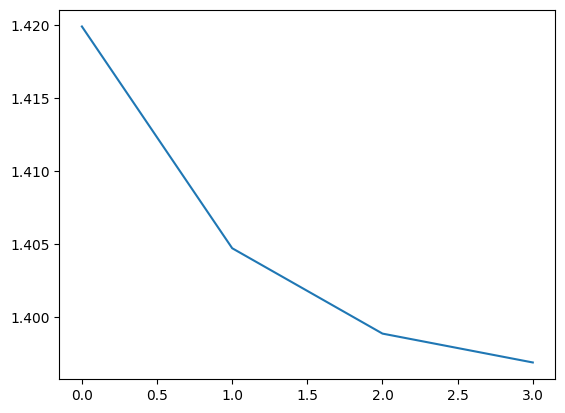

 53%|█████▎    | 399/756 [06:37<05:56,  1.00it/s]

index : 399, current loss : 1.39334743990934


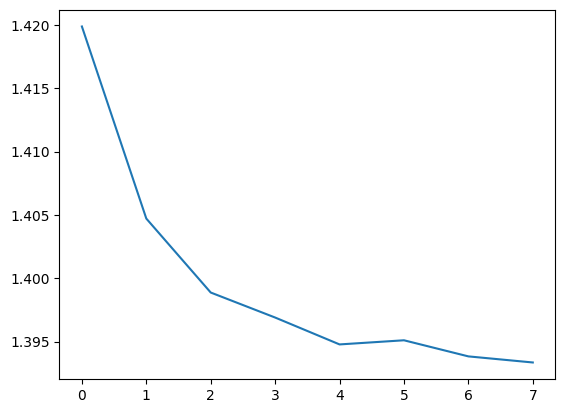

 79%|███████▉  | 599/756 [09:57<02:36,  1.00it/s]

index : 599, current loss : 1.3915446919073446


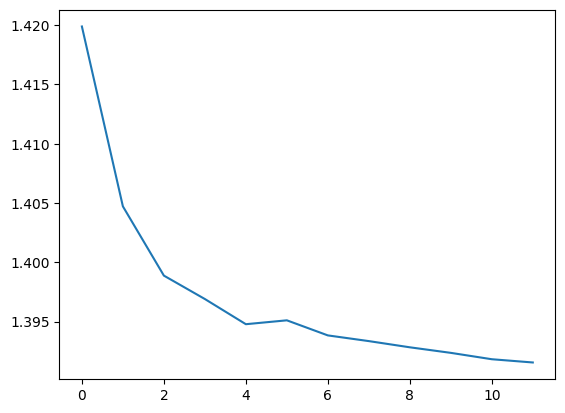

 90%|████████▉ | 679/756 [11:18<01:16,  1.00it/s]


KeyboardInterrupt: ignored

In [ ]:
import torch.nn.functional as F
import numpy as np

torch.cuda.empty_cache()

batch_loss = 0
losses = []

for i in range(epochs):
  batch_loss = 0
  print(f"epoch {i} is running,")
  model.train()
  model2.train()
  for idx, batch in enumerate(tqdm.tqdm(train_dataloader)):
    if idx > len(train_dataloader)-2:
      continue
    q_inputs = batch['conv'].to(device)
    c_inputs = batch['info'].to(device)
    
    q_outputs = model(input_ids=q_inputs['input_ids'][:,0,:], attention_mask=q_inputs['attention_mask'][:,0,:]).pooler_output # pooler_output이 [CLS] 토큰의 임베딩 벡터
    c_outputs = model2(input_ids=c_inputs['input_ids'][:,0,:], attention_mask=c_inputs['attention_mask'][:,0,:]).pooler_output

    # 각각 전부와 cosine 유사도 구하기. 근데 matmul이 다야?
    sim_scores = torch.matmul(q_outputs, torch.transpose(c_outputs, 0, 1))

    targets = torch.arange(0, batch_size).long().to(device)

    sim_scores = F.log_softmax(sim_scores, dim=1)
    loss = F.nll_loss(sim_scores, targets, reduction="mean") # 

    loss.backward()
    optimizer.step()
    optimizer2.step()
    model.zero_grad()
    model2.zero_grad()

    batch_loss += loss.detach().cpu().numpy()
    torch.cuda.empty_cache()

    if idx%50 == 49:
      losses.append(batch_loss/idx)

    if idx%200 == 199:
      print(f"index : {idx}, current loss : {batch_loss/idx}")
      plt.plot(np.arange(len(losses)), losses)
      plt.show()

  # epoch
  torch.save(model.state_dict(), GOOGLE_DRIVE_PATH + "q_encoder.pt")
  torch.save(model2.state_dict(), GOOGLE_DRIVE_PATH + "c_encoder.pt")

In [ ]:
torch.save(model.state_dict(), GOOGLE_DRIVE_PATH + "q_encoder.pt")
torch.save(model2.state_dict(), GOOGLE_DRIVE_PATH + "c_encoder.pt")

### check validation

In [ ]:
def ready_embedding_index(model_emb):
  # set embedding vectors for each movie

  sentence_embeddings=[]
  for value in tqdm.tqdm(movie_infos):
    text_of_movie = value['text']
    tokenized = tokenizer(text_of_movie, max_length=512, return_tensors='pt')
    input_ids, attention_mask = tokenized['input_ids'].to(device), tokenized['attention_mask'].to(device)

    with torch.no_grad():
      model_output = model_emb(input_ids=input_ids, attention_mask=attention_mask).pooler_output.cpu().detach().numpy()
      sentence_embeddings.append(model_output)

  d = sentence_embeddings[0].shape[1]  # number of dimensions
  index = faiss.IndexFlatIP(d)  # create a cosine similarity index
  for i in range(len(sentence_embeddings)):
      index.add(sentence_embeddings[i])  # add the sentence embedding to the index
  return index, sentence_embeddings

index, se = ready_embedding_index(model2)

100%|██████████| 17691/17691 [10:33<00:00, 27.91it/s]


In [ ]:
def get_movie_recommendations(index, model_emb, conversation, k=10):
  """
  k means how many shoud be found.
  """  
  # tokenized = tokenizer(conversation, return_tensors='pt')
  input_ids, attention_mask = conversation['input_ids'].to(device), conversation['attention_mask'].to(device)
  with torch.no_grad():
    model_output = model_emb(input_ids=input_ids, attention_mask=attention_mask)
    CLS_TOKEN = model_output.pooler_output.cpu().detach().numpy()

  # k is number of nearest neighbors to search for
  D, I = index.search(CLS_TOKEN, k)  # search for the nearest neighbor

  movie_list = []
  for i in range(k):
    movie_list.append({
        "title": movie_infos[I[0][i]]['title'],
        "key": movie_infos[I[0][i]]['key']
        })
  cosine_similarity = D[0][0]
  print("top 1 score : ", cosine_similarity)
  return movie_list

In [ ]:
count=0
matched_movie=[]

for data in tqdm.tqdm(ourdata):
  conv = data['conv']
  returned_list = get_movie_recommendations(index, model, conv, 50)
  matched = set([r.strip().lower() for r in returned_list]) & set([re.sub(r'\([^)]*\)', "", c).strip().lower() for c in red['answer']])
  if len(matched)>0:
    # print(matched)
    matched_movie.append(list(matched)[0])
    count += 1
    print("one is matched!", matched, f"it is retrieved as {matched.indexof(list(matched)[0])}th")

print(f"\n All Corrected movie is {count} .\n")

In [ ]:
count=0
matched_movie=[]

for idx in tqdm.tqdm(range(len(pairs))):
  red = pairs[idx]['redial']
  returned_list = get_movie_recommendations(index, model, red['message'], 50)
  matched = set([r.strip().lower() for r in returned_list]) & set([re.sub(r'\([^)]*\)', "", c).strip().lower() for c in red['answer']])
  if len(matched)>0:
    # print(matched)
    matched_movie.append(list(matched)[0])
    count += 1
    print("one is matched!", matched, f"it is retrieved as {matched.indexof(list(matched)[0])}th")

print(f"\n All Corrected movie is {count} .\n")

### remained

In [ ]:
def ready_embedding_index(model=""):
  # set embedding vectors for each movie

  sentence_embeddings=[]
  now = time.time()
  for idx in tqdm.tqdm(range(len(pairs))):
  # for idx in tqdm.tqdm(validation_dataset.indices):
    value = pairs[idx]['movie_infos']
    text_of_movie = value['text'][:1500]
    tokenized = tokenizer(text_of_movie, return_tensors='pt')
    input_ids, attention_mask = tokenized['input_ids'].to(device), tokenized['attention_mask'].to(device)

    if len(input_ids[0]) > 514:
      print("one is continued", len(input_ids[0]))
      continue

    with torch.no_grad():
      model_output = model(input_ids=input_ids, attention_mask=attention_mask)

    CLS_TOKEN = model_output.pooler_output.cpu().detach().numpy() # hidden states의 마지막 토큰(CLS 토큰)
    sentence_embeddings.append(CLS_TOKEN)

    # for check progress..
    if idx%1000==0:
      print(f"{idx}/{len(validation_dataset)} .. ", time.time() - now, "-seconds")
      now = time.time()

  # sentence_embeddings = torch.load(GOOGLE_DRIVE_PATH + "embeds.pt")
  # print(sentence_embeddings.shape)

  d = sentence_embeddings[0].shape[1]  # number of dimensions
  index = faiss.IndexFlatIP(d)  # create a cosine similarity index

  for i in range(len(sentence_embeddings)):
      index.add(sentence_embeddings[i])  # add the sentence embedding to the index
  
  return index, sentence_embeddings

In [ ]:
# del sdemodel

# class Sdeencoder(torch.nn.Module):
#   def __init__(self):
#     super(Sdeencoder, self).__init__()
#     self.model=model
#     self.question_embedding = model.embeddings
#     self.answer_embedding = model.embeddings

#   def forward(self, input_ids, attention_mask, typed="question"):
#     print("들어옴")
#     last_hidden_state = self.model(input_ids, attention_mask=attention_mask).last_hidden_state
#     pooler_output = self.model(input_ids, attention_mask=attention_mask).pooler_output
#     print("들어옴22", pooler_output.shape)
#     if typed == "question":
#       print("last_hidden_state: ", last_hidden_state.shape)
#       x=self.answer_embedding(last_hidden_state)
#       print("들어옴3")
#       return x
#     elif typed == "answer":
#       x=self.answer_embedding(last_hidden_state)
#       return x

# sdemodel = Sdeencoder()

In [ ]:
# import random
# import numpy as np

# batch_size=4
# class PairDataset(torch.utils.data.Dataset):
#   def __init__(self):
#     super(PairDataset, self).__init__()
#     self.data_list = []
#     random_order = random.sample(range(len(pairs)), len(pairs))

#     pp=0
#     now_movies = []
#     now_mentioned_movies = []
#     next_movies = []
#     next_mentioned_movies = []
#     next_movies2 = []
#     next_mentioned_movies2 = []
#     for i, idx in tqdm.tqdm(enumerate(random_order)):
#       q_seqs = tokenizer(pairs[idx]['redial']['message'], max_length=512, padding="max_length", truncation=True, return_tensors='pt')
#       c_seqs = tokenizer(pairs[idx]['movie_infos']['text'], max_length=512, padding="max_length", truncation=True, return_tensors='pt')

#       if len(set(pairs[idx]['redial']['mentioned']) & set(now_mentioned_movies))>0:
#         pp+=1
#         if len(set(pairs[idx]['redial']['mentioned']) & set(next_mentioned_movies))>0:
#           next_movies2.append({
#             "conv":q_seqs,
#             "info":c_seqs,            
#           })
#           next_mentioned_movies2 += pairs[idx]['redial']['mentioned']
#         else:
#           next_movies.append({
#             "conv":q_seqs,
#             "info":c_seqs,            
#           })
#           next_mentioned_movies += pairs[idx]['redial']['mentioned']
#       else:
#         now_mentioned_movies += pairs[idx]['redial']['mentioned']
#         now_movies.append({
#           "conv":q_seqs,
#           "info":c_seqs,
#         })
#       if len(now_movies)>3:
#         self.data_list += now_movies
#         if len(next_movies) > 3:
#           print(len(next_movies))
#         now_movies, next_movies = next_movies[:4], next_movies2
#         next_movies2=[]
#         now_mentioned_movies, next_mentioned_movies = next_mentioned_movies, next_mentioned_movies2
#         next_mentioned_movies2 = []
  
#   def __len__(self):
#     return len(self.data_list)

#   def __getitem__(self, idx):
#     return self.data_list[idx]

In [ ]:
import torch.nn.functional as F

torch.cuda.empty_cache()

batch_loss = 0
losses = []

# negative log likelihood는 softmax와 합쳐질 때 매우 흥미롭다.
for i in range(epochs):
  batch_loss = 0
  print(f"epoch {i} is running,,")
  q_model.train()
  c_model.train()
  for idx, batch in enumerate(tqdm.tqdm(train_dataloader)):
    print(batch)

    q_inputs = batch['conv'].to(device)
    c_inputs = batch['info'].to(device)
    
    q_outputs = q_model(input_ids=q_inputs['input_ids'][:,0,:], attention_mask=q_inputs['attention_mask'][:,0,:]).pooler_output # pooler_output이 [CLS] 토큰의 임베딩 벡터
    c_outputs = c_model(input_ids=c_inputs['input_ids'][:,0,:], attention_mask=c_inputs['attention_mask'][:,0,:]).pooler_output
    # print("is this real CLS token? : ", c_outputs.shape, q_outputs.shape) # 768, 4
    # print("what is this ? : ", torch.transpose(c_outputs, 0, 1).shape)

    # 각각 전부와 cosine 유사도 구하기. 근데 matmul이 다야?
    sim_scores = torch.matmul(q_outputs, torch.transpose(c_outputs, 0, 1))
    # torch.transpose(c_outputs, 0, 1) : [768, 4]

    print("sim_scores.shape : ", sim_scores.shape)
    targets = torch.arange(0, batch_size).long().to(device)

    # log softmax를 취하고 nll_loss를 계산. 정답 class와 나머지 Class로 본뒤 정답 class에서 값이 높도록 하는거구나..?
    sim_scores = F.log_softmax(sim_scores, dim=1) 
    loss = F.nll_loss(sim_scores, targets, reduction="mean") # 

    loss.backward()
    optimizer.step()
    q_model.zero_grad()
    c_model.zero_grad()

    batch_loss += loss.detach().cpu().numpy()
    torch.cuda.empty_cache()

    if idx%50 == 49:
      losses.append(batch_loss/idx)

    if idx%500 == 499:
      print(f"index : {idx}, current loss : {batch_loss/idx}")
      plt.plot(losses)
      plt.show()

  # epoch
  torch.save(q_model.state_dict(), GOOGLE_DRIVE_PATH + "q_encoder.pt")
  torch.save(c_model.state_dict(), GOOGLE_DRIVE_PATH + "c_encoder.pt")
  
  # # check with validation data
  # valid_loss=0
  # for idx, batch in tqdm.tqdm(enumerate(valid_dataloader)):
  #   q_model.eval()
  #   c_model.eval()
  #   batch = tuple(t for t in batch)
  #   q_inputs = batch['conv']
  #   c_inputs = batch['info']
  #   q_outputs = q_model(input_ids=q_inputs['input_ids'][:,0,:], attention_mask=q_inputs['attention_mask'][:,0,:]).pooler_output # pooler_output이 [CLS] 토큰의 임베딩 벡터
  #   c_outputs = c_model(input_ids=c_inputs['input_ids'][:,0,:], attention_mask=c_inputs['attention_mask'][:,0,:]).pooler_output

  #   # positive pair cosine 유사도 구하기
  #   sim_scores = torch.matmul(q_outputs, torch.transpose(c_outputs, 0, 1))
  #   # negative pair cosine 유사도 구하기
  #   targets = torch.arange(0, batch_size).long()

  #   # log softmax를 취하고 nll_loss를 계산
  #   sim_scores = F.log_softmax(sim_scores, dim=1)
  #   loss = F.nll_loss(sim_scores, targets, reduction="mean")
  #   valid_loss += loss.detach().cpu().numpy()
  # print("validation loss is : ", valid_loss)

In [ ]:
squad_dataset['train'][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

epoch 0 is running,


  2%|▏         | 499/21900 [07:47<5:34:26,  1.07it/s]

index : 499, current loss : 2.0332841498101644


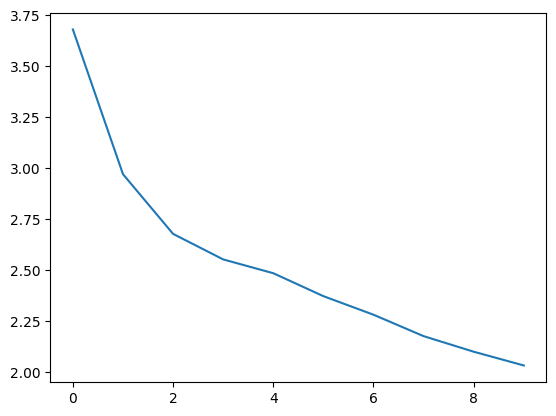

  5%|▍         | 999/21900 [15:36<5:28:32,  1.06it/s]

index : 999, current loss : 1.7381552259723942


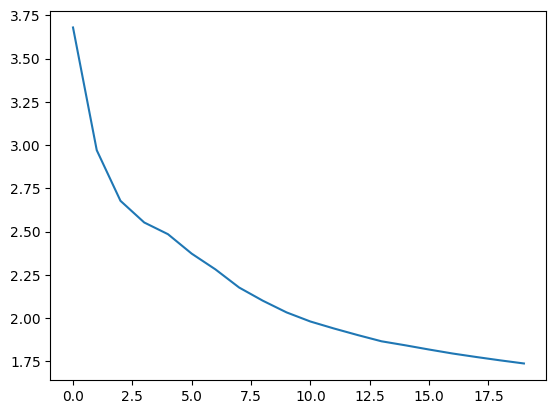

  5%|▍         | 1067/21900 [16:41<5:25:51,  1.07it/s]


KeyboardInterrupt: ignored

In [ ]:
import torch.nn.functional as F
import numpy as np

torch.cuda.empty_cache()

batch_loss = 0
losses = []
batch_size=4

for i in range(epochs):
  batch_loss = 0
  print(f"epoch {i} is running,")
  model.train()
  model2.train()
  for idx, batch in enumerate(tqdm.tqdm(train_dataloader_squad)):
    q_inputs = batch['question'].to(device)
    c_inputs = batch['context'].to(device)
    
    q_outputs = model(input_ids=q_inputs['input_ids'][:,0,:], attention_mask=q_inputs['attention_mask'][:,0,:]).pooler_output # pooler_output이 [CLS] 토큰의 임베딩 벡터
    c_outputs = model2(input_ids=c_inputs['input_ids'][:,0,:], attention_mask=c_inputs['attention_mask'][:,0,:]).pooler_output
    # print("is this real CLS token? : ", c_outputs.shape, q_outputs.shape) # 768, 4
    # print("what is this ? : ", torch.transpose(c_outputs, 0, 1).shape)

    # 각각 전부와 cosine 유사도 구하기. 근데 matmul이 다야?
    sim_scores = torch.matmul(q_outputs, torch.transpose(c_outputs, 0, 1))
    # torch.transpose(c_outputs, 0, 1) : [768, 4]

    # print("sim_scores.shape : ", sim_scores.shape) # 4*4..? 맞구나! batch_size * batch_size
    targets = torch.arange(0, batch_size).long().to(device)

    # log softmax를 취하고 nll_loss를 계산. 정답 class와 나머지 Class로 본뒤 정답 class에서 값이 높도록 하는거구나..?
    sim_scores = F.log_softmax(sim_scores, dim=1) 
    loss = F.nll_loss(sim_scores, targets, reduction="mean") # 

    loss.backward()
    optimizer.step()
    optimizer2.step()
    model.zero_grad()
    model2.zero_grad()

    batch_loss += loss.detach().cpu().numpy()
    torch.cuda.empty_cache()

    if idx%50 == 49:
      losses.append(batch_loss/idx)

    if idx%500 == 499:
      print(f"index : {idx}, current loss : {batch_loss/idx}")
      plt.plot(np.arange(len(losses)), losses)
      plt.show()

  # epoch
  torch.save(model.state_dict(), GOOGLE_DRIVE_PATH + "q_encoder_squad.pt")
  torch.save(model2.state_dict(), GOOGLE_DRIVE_PATH + "c_encoder_squad.pt")